In [1]:
%load_ext autoreload
%autoreload 2
import os, argparse, random, math, sys, pickle, scipy
import pandas as pd
from tqdm import tqdm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import bootstrap
# plt.rcParams["font.family"] = "Serif"
plt.rcParams.update({
    "text.usetex": False,
    "font.family": "Serif",  # Use a serif font
})
sys.path.append("..")
from data.amr_uti import generate_amr_uti_nc

In [ ]:
def get_full_eval_df(num_reps, checkpoint_dir, model): 
    eval_df = []
    for rep in range(num_reps):
        curr_cp_dir = os.path.join(checkpoint_dir, f"rep={rep}", model)
        curr_eval_path = os.path.join(curr_cp_dir, f"eval.csv")
        assert os.path.isfile(curr_eval_path), curr_eval_path
        curr_eval_df = pd.read_csv(curr_eval_path)
        curr_eval_df["rep"] = rep
        eval_df.append(curr_eval_df)
    eval_df = pd.concat(eval_df)
    return eval_df    
map_dict = {
    "sbd-tlearner": "SBD (T-learner)", "cfd-tlearner": "CFD (T-learner)", "lobster": "CFD (LobsterNet)"}
model_strs = ["sbd-tlearner", "cfd-tlearner", "lobster"]

In [ ]:
num_reps=20
nc_rates = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
nc_type="one-sided"
eval_df_list = []
for nc_rate in tqdm(nc_rates): 
    for prescriptions in [["NIT"]]:
        ihdp_setting = f"type={nc_type}/rate={nc_rate}/prescriptions={prescriptions}"
        for model in model_strs:
            ihdp_mod_checkpoint_dir = os.path.join("..", "..", "checkpoints", f"AMR-UTI/{ihdp_setting}")
            assert os.path.isdir(ihdp_mod_checkpoint_dir), ihdp_mod_checkpoint_dir
            ihdp_mod_eval_df = get_full_eval_df(num_reps, ihdp_mod_checkpoint_dir, model)
            ihdp_mod_eval_df["setting"] = ihdp_setting
            ihdp_mod_eval_df["model"] = model
            ihdp_mod_eval_df["nc_rate"] = nc_rate
            ihdp_mod_eval_df["prescription"] = prescriptions[0]
            eval_df_list.append(ihdp_mod_eval_df)
one_sided_amruti_eval_df = pd.concat(eval_df_list)
one_sided_amruti_eval_df.model = one_sided_amruti_eval_df.model.map(map_dict)
one_sided_amruti_eval_df = one_sided_amruti_eval_df.drop(columns=["delta_A"]).merge(
    one_sided_amruti_eval_df.groupby(["rep", "setting", "nc_rate"])["delta_A"].mean().reset_index(), 
    on=["rep", "setting", "nc_rate"])

  0%|          | 0/9 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:06<00:00,  1.38it/s]


In [ ]:
# load two-sided AMR-UTI eval results
num_reps=5
nc_type="two-sided"
nc_rates = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.25, 0.65]
eval_df_list = []
for nc_rate in tqdm(nc_rates): 
    for idx, prescriptions in enumerate([["NIT", "CIP"]]):
        ihdp_setting = f"type={nc_type}/rate={nc_rate}/prescriptions={prescriptions}"
        for model in model_strs:
            ihdp_mod_checkpoint_dir = os.path.join("..", "..", "checkpoints", f"AMR-UTI/{ihdp_setting}")
            assert os.path.isdir(ihdp_mod_checkpoint_dir)
            ihdp_mod_eval_df = get_full_eval_df(num_reps, ihdp_mod_checkpoint_dir, model)
            ihdp_mod_eval_df["setting"] = ihdp_setting
            ihdp_mod_eval_df["model"] = model
            ihdp_mod_eval_df["nc_rate"] = nc_rate
            ihdp_mod_eval_df["type"] = idx
            eval_df_list.append(ihdp_mod_eval_df)
two_sided_amruti_eval_df = pd.concat(eval_df_list)
two_sided_amruti_eval_df.model = two_sided_amruti_eval_df.model.map(map_dict)
two_sided_amruti_eval_df = two_sided_amruti_eval_df.drop(columns=["delta_A"]).merge(
    two_sided_amruti_eval_df.groupby(["rep", "setting", "nc_rate"])["delta_A"].mean().reset_index(), 
    on=["rep", "setting", "nc_rate"])

  0%|          | 0/13 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:01<00:00, 11.54it/s]


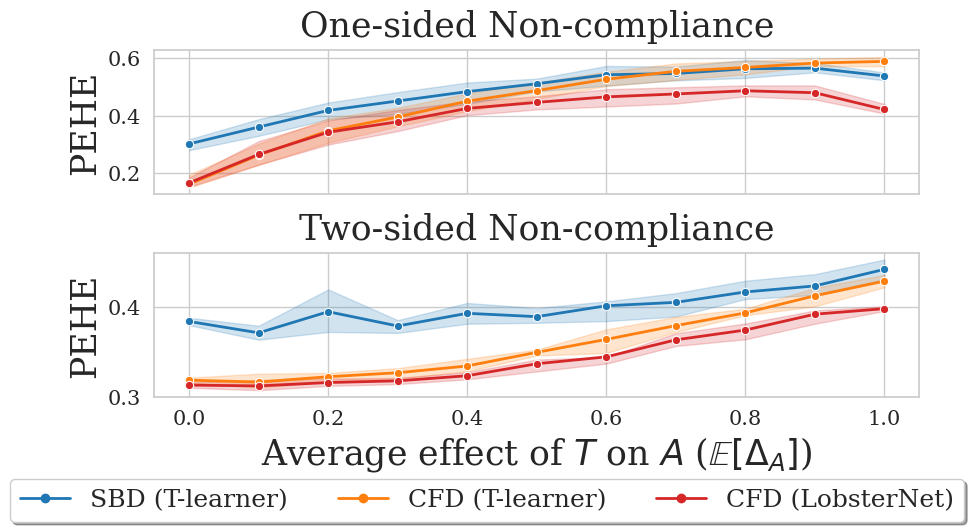

In [5]:
sns.set(font="Serif", style="whitegrid", rc={"lines.linewidth": 2.0})
palette = sns.color_palette(['tab:blue', 'tab:orange', 'tab:red'])
fig, axes = plt.subplots(2, 1, figsize=(10*0.9, 5), sharex="col")
plot_one_sided_amruti_eval_df = one_sided_amruti_eval_df[one_sided_amruti_eval_df.model.isin(["SBD (T-learner)", "SBD (DragonNet)", "CFD (T-learner)", "CFD (LobsterNet)"])].copy()
plot_one_sided_amruti_eval_df.nc_rate = (plot_one_sided_amruti_eval_df.nc_rate * 100).map(lambda x: f"{int(x)}%")
plot_one_sided_amruti_eval_df["delta_A"] = plot_one_sided_amruti_eval_df.delta_A.round(decimals=1)
plot_two_sided_amruti_eval_df = two_sided_amruti_eval_df[two_sided_amruti_eval_df.model.isin(["SBD (T-learner)", "SBD (DragonNet)" , "CFD (T-learner)", "CFD (LobsterNet)"])].copy()
plot_two_sided_amruti_eval_df.nc_rate = (plot_two_sided_amruti_eval_df.nc_rate * 100).map(lambda x: f"{int(x)}%")
plot_two_sided_amruti_eval_df["delta_A"] = plot_two_sided_amruti_eval_df.delta_A.round(decimals=1)
sns.lineplot(data=plot_one_sided_amruti_eval_df[(plot_one_sided_amruti_eval_df.label=="assign effect PEHE") & (plot_one_sided_amruti_eval_df.prescription=="NIT")], 
             x="delta_A", y="value", hue="model", style="model", ax=axes[0], markers=["o", "o", "o"], palette=palette,
             errorbar=lambda x: np.percentile(x, (25, 75)), estimator="mean", dashes=False)
sns.lineplot(data=plot_two_sided_amruti_eval_df[(plot_two_sided_amruti_eval_df.label=="assign effect PEHE") & (plot_two_sided_amruti_eval_df.type==0)], 
             x="delta_A", y="value", hue="model", style="model", ax=axes[1], markers=["o", "o", "o"], palette=palette,
             errorbar=lambda x: np.percentile(x, (25, 75)), estimator="mean", dashes=False)
axes[0].set_ylabel("PEHE", fontsize=25)
axes[1].set_ylabel("PEHE", fontsize=25)
axes[0].set_title(r"One-sided Non-compliance", fontsize=25, pad=10)
axes[1].set_title(r"Two-sided Non-compliance", fontsize=25, pad=10)
axes[0].tick_params(axis='both', which='major', labelsize=15)
axes[1].tick_params(axis='both', which='major', labelsize=15)
axes[0].set_xlabel(None)
axes[1].set_xlabel(r"Average effect of $T$ on $A$ ($\mathbb{E}[\Delta_A]$)", fontsize=25)
axes[0].get_legend().remove()
axes[1].get_legend().remove()
fig.legend(*axes[0].get_legend_handles_labels(), loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=3, fontsize=18,
           fancybox=True, shadow=True)
fig.tight_layout()

In [6]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, h


print('one-sided')
for method in one_sided_amruti_eval_df.model.unique():
    print(f"\t{method}: ", end="")
    mean, ci_pm = mean_confidence_interval(
        one_sided_amruti_eval_df[(one_sided_amruti_eval_df.model==method) & (one_sided_amruti_eval_df.label=="assign effect PEHE")].value)
    print(f"{mean:.3f} $\pm$ {ci_pm:.3f}")

print('two-sided')
for method in two_sided_amruti_eval_df.model.unique():
    print(f"\t{method}: ", end="")
    mean, ci_pm = mean_confidence_interval(
        two_sided_amruti_eval_df[(two_sided_amruti_eval_df.model==method) & (two_sided_amruti_eval_df.label=="assign effect PEHE")].value)
    print(f"{mean:.3f} $\pm$ {ci_pm:.3f}")

one-sided
	SBD (T-learner): 0.479 $\pm$ 0.013
	CFD (T-learner): 0.442 $\pm$ 0.019
	CFD (LobsterNet): 0.400 $\pm$ 0.014
two-sided
	SBD (T-learner): 0.400 $\pm$ 0.006
	CFD (T-learner): 0.362 $\pm$ 0.009
	CFD (LobsterNet): 0.348 $\pm$ 0.008
